<a href="https://colab.research.google.com/github/GillianJ/Projects/blob/main/SkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SkimLit project**

The purpose of this project is to build an NLP model to make reading medical abstracts easier.

**Problem in a sentence**

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**Solution in a sentence**

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

  📖 **Resources:** 
  1. Where our data is coming from: https://arxiv.org/abs/1710.06071
  2. Where our model is coming from: Neural networks for joint sentence classification in medical paper abstracts. https://arxiv.org/pdf/1612.05251.pdf 


**What we're going to cover**

Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

  * Downloading a text dataset (PubMed RCT200k from GitHub)
  * Writing a preprocessing function to prepare our data for modelling
  * Setting up a series of modelling experiments
    * Making a baseline (TF-IDF classifier)
    * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
  * Building our first multimodal model (taking multiple types of data inputs)
  *Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild


**Confirm access to a GPU**

Since I am going to be building deep learning models, I need to make sure I have a GPU.

In Google Colab, this can be set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

With no access to a GPU, the models I'm building here will likely take up to 10x longer to run.

In [ ]:
# Check for GPU
!nvidia-smi -L


**Get data**

Before I can start building a model, I've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

I can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md



Checking the contents of the downloaded repository, I can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the README file from the GitHub page, we get the following information:

  * PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
  * PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).
  * Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset I am going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Why this one?

Rather than working with the whole 200k dataset, I'll keep my experiments quick by starting with a smaller subset. I could've chosen the dataset with numbers instead of having them replaced with @ but I didn't.

Let's check the file contents.

In [ ]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Beautiful, looks like I've got three separate text files:

  * train.txt - training samples.
  * dev.txt - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
  * test.txt - test samples.

To save myself from typing out the filepath to our target directory each time, I'll turn it into a variable.


In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames


['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']


**Preprocess data**

To get familiar and understand I have to preparemy data for the deep learning models, I've got to visualize it.

Because the data is in the form of text files, I will write some code to read each of the lines in a target file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()


Alright, now I've got a little function, get_lines() which takes the filepath of a text file, opens it, reads each of the lines and returns them.

I will try it out on the training data (train.txt).

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

I will write a function to perform the following steps:

  * Take a target file of abstract samples.
  * Read the lines in the target file.
  * For each line in the target file:
    * If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
      * Keep count of the number of lines in a sample.
  * If the line begins with \n mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the \t as the label of the line.
  * Record the text after the \t as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * "line_number" - the position of the line in the abstract (e.g. 3).
  * "target" - the role of the line in the abstract (e.g. OBJECTIVE).
  * "text" - the text of the line in the abstract.
  * "total_lines" - the total lines in an abstract sample (e.g. 14).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

Alright, I've got a little function, get_lines() which takes the filepath of a text file, opens it, reads each of the lines and returns them.

I will try it out on the training data (train.txt).


In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

That's one good looking function. I will use it to preprocess each of our RCT 20k datasets.

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 598 ms, sys: 126 ms, total: 724 ms
Wall time: 727 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Fantastic! Looks like the preprocess_text_with_line_numbers() function worked great.

How about I turn our list of dictionaries into pandas DataFrame's so we visualize them better?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Now the data is in DataFrame form, we can perform some data analysis on it.

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


Looks like sentences with the OBJECTIVE label are the least common.

How about I check the distribution of our abstract lengths?

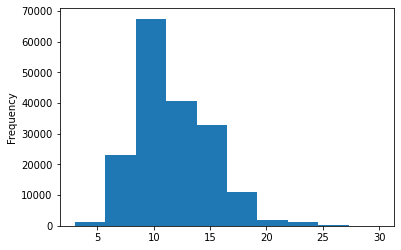

In [ ]:
train_df.total_lines.plot.hist();


**Get lists of sentences**

When I build the deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

I can get these easily from our DataFrames by calling the tolist() method on our "text" columns.

In [ ]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

**Make numeric labels (ML models require numeric labels)**

I'm going to create one hot and label encoded labels.

I could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels I'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

**Label encode labels**

In [ ]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

Now that I've trained an instance of LabelEncoder, I can get the class names and number of classes using the classes_ attribute.


In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

**Creating a series of model experiments**

I've proprocessed the data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

I'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, I
'll train it on the training data and evaluate it on the validation data.

**Model 0: Getting a baseline**

THE first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, I'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify the sentences using the MultinomialNB aglorithm.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

Due to the speed of the Multinomial Naive Bayes algorithm, it trains very quickly.

I can evaluate the model's accuracy on the validation dataset using the score() method.

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Nice! Looks like 72.1% accuracy will be the number to beat with our deeper models.

Now I will make some predictions with the baseline model to further evaluate it.

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate the baseline's predictions, I'll import the calculate_results() function I created in the previous notebook and added it to my helper_functions.py script to compare them to the ground truth labels.

More specificially the calculate_results() function will help me obtain the following:

  * Accuracy
  * Precision
  * Recall
  * F1-score

**Download helper functions script**

I will get our helper_functions.py script we've been using to store helper functions we've created in previous notebooks.

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-16 13:48:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-16 13:48:18 (70.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

**Preparing our data for deep sequence models**

I've got a working baseline to try and improve upon.

But before I start building deeper models, I've got to create vectorization and embedding layers.

The vectorization layer will convert the text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating the vectorization and embedding layers, I'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

Since I'll be turning the sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When the model goes through the sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, I want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

I will write some code to find the average length of sentences in the training set.

In [ ]:
# how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

# average of 26 words per sentence

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <a list of 10 Patch objects>)

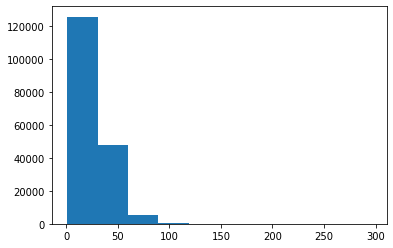

In [ ]:
# what's the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=10)

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

I can use NumPy's percentile to find the value which covers 95% of the sentence lengths.



In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Wonderful! It looks like 95% of the sentences in the training set have a length of 55 tokens or less.

When I create the tokenization layer, I'll use this value to turn all of the sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

🤔 **Question:** Why 95%?

I could use the max sentence length of the sentences in the training set.

In [ ]:
# Maximum sentence length in the training set
max(sent_lens)

296

**Create text vectorizer**

Now that I've got a little more information about our texts, I'll create a way to turn it into numbers.

To do so, I'll use the TextVectorization layer from TensorFlow.

I'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (the desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So I'll use that as the max_tokens parameter.

In [ ]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences


Great! Looks like the text_vectorizer is ready, I will now adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)


In [ ]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
thirty-eight patients were assigned to group a ( @ lobectomies , @ segmentectomies ) and @ to group b ( @ lobectomies , @ segmentectomies ) .

Length of text: 27

Vectorized text:
[[ 5954    12     9   123     6    13     8 22653 28621     3     6    13
    186 22653 28621     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


And if I wanted to figure out the configuration of the text_vectorizer I can use the get_config() method.

In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

**Create custom text embedding**

THe token_vectorization layer maps the words in the text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of the text, I use an **embedding.**

As the model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in the corpus.

We can create a trainable embedding layer using TensorFlow's Embedding layer.

Once again, the main parameters I am concerned with here are the inputs and outputs of the Embedding layer.

The input_dim parameter defines the size of the vocabulary. And the output_dim parameter defines the dimension of the embedding output.
Once created, the embedding layer will take the integer outputs of the text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

Let's see it in action.

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

# 1 sequence long with 55 tokens and each token is embedded in a 128 feature vector. this is the embedded sentence shape.

Sentence before vectorization:
thirty-eight patients were assigned to group a ( @ lobectomies , @ segmentectomies ) and @ to group b ( @ lobectomies , @ segmentectomies ) .

Sentence after vectorization (before embedding):
[[ 5954    12     9   123     6    13     8 22653 28621     3     6    13
    186 22653 28621     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04804419 -0.0076835   0.00892811 ...  0.02490327  0.04562478
    0.01009287]
  [ 0.0418005  -0.03909047  0.04511298 ...  0.01941102 -0.0091805
   -0.01075871]
  [ 0.00622528  0.0332986   0.04331542 ... -0.02496788 -0.0103122
   -0.0209061 ]
  ...
  [ 0.01213206  0.01198969  0.04255339 ... -0.01302832 -0.03044598
   -0.00583316]
  [ 0.01213206  0.01198969  0.04255339 ... -0.01302832 -0.03044598
   -0

**Create datasets (as fast as possible)**

I've gone through all the trouble of preprocessing the datasets to be used with a machine learning model, however, there are still a few steps I can use to make them work faster with my models.

Namely, the tf.data API provides methods which enable faster data loading.

  📖** Resource: **For best practices on data loading in TensorFlow, check out the following:

  * tf.data: Build TensorFlow input pipelines https://www.tensorflow.org/guide/data
  * Better performance with the tf.data API https://www.tensorflow.org/guide/data_performance

The main steps I'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads the data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset I can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

**Model 1: Conv1D with token embeddings**

Alright, I've now got a way to numerically represent the text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

`` Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability) `` 

The main component I'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model I am going to build is a 1-dimensional Convolutional Neural Network.

I am also going to be following the standard machine learning workflow of:

  * Build model
  * Train model
  * Evaluate model (make predictions and compare to ground truth)

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

Wonderful! I've got the first deep sequence model built and ready to go.

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If I were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

It's time to fit the model to the training data but I am going to make a mindful change.

Since the training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, I am going to run them on a subset of the training dataset.

More specifically, I'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 60s 105ms/step - loss: 0.9136 - accuracy: 0.6393 - val_loss: 0.6892 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 58s 103ms/step - loss: 0.6637 - accuracy: 0.7544 - val_loss: 0.6390 - val_accuracy: 0.7686
Epoch 3/3
562/562 [==============================] - 58s 103ms/step - loss: 0.6233 - accuracy: 0.7723 - val_loss: 0.5987 - val_accuracy: 0.7856


I've got my first trained deep sequence model, and it didn't take too long.

Time to make some predictions with our model and then evaluate them.

In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.6018 - accuracy: 0.7841


[0.6017971038818359, 0.7841255068778992]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.0638483e-01, 2.1744293e-01, 8.8796385e-02, 2.5618315e-01,
        3.1192683e-02],
       [4.6255133e-01, 2.7578685e-01, 1.2229347e-02, 2.4234869e-01,
        7.0836856e-03],
       [1.5057582e-01, 1.0199792e-02, 1.9788949e-03, 8.3720642e-01,
        3.9158029e-05],
       ...,
       [3.7466716e-06, 9.7116054e-04, 8.9677767e-04, 3.7475863e-06,
        9.9812454e-01],
       [5.4957677e-02, 4.6927291e-01, 8.6427115e-02, 5.9705693e-02,
        3.2963657e-01],
       [2.0703349e-01, 5.9100920e-01, 5.3320728e-02, 5.3066663e-02,
        9.5569909e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.41255130411757,
 'f1': 0.7816918446780285,
 'precision': 0.7804773662384582,
 'recall': 0.7841255130411757}

**Model 2: Feature extraction with pretrained token embeddings**

Training my own embeddings took a little while to run, slowing our experiments down.

Since I're moving towards replicating the model architecture in https://arxiv.org/pdf/1612.05251.pdf (Neural Networks for Joint Sentence Classification in Medical Paper Abstracts), it mentions they used a https://nlp.stanford.edu/projects/glove/ (pretrained GloVe embedding) as a way to initialise their token embeddings.

To emulate this, let's see what results I can get with the https://tfhub.dev/google/universal-sentence-encoder/4 (pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.)

The feature extractor model I am building using a pretrained embedding from TensorFlow Hub.

To download the pretrained USE into a layer I can use in the model, I can use the hub.KerasLayer class.

I'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to the own data.


In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

Beautiful, now my pretrained USE is downloaded and instantiated as a hub.KerasLayer instance, I will test it out on a random sentence.

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
this suggests that @-c-cycle alterations in mdd are state-associated , possibly resulting from high levels of acute ( psychological ) stress , and may provide a treatment target to reduce cardiovascular risk in this population .

Sentence after embedding:
[-0.03119756  0.06465914  0.00210436 -0.03694934  0.02931661  0.00013799
 -0.00421552 -0.00406719  0.04218897 -0.05661973  0.09164661 -0.04969642
  0.00062336  0.05341598  0.06045795 -0.00918851 -0.09560923  0.03163569
  0.03417427  0.02194471 -0.05276514  0.01804792  0.0740042  -0.07545408
  0.01595974 -0.00805009  0.00472721  0.00825979 -0.04890399  0.03305428] (truncated output)...

Length of sentence embedding:
512


**Building and fitting an NLP feature extraction model from TensorFlow Hub**

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of the model, I can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because I set training=False when I instatiated our USE feature extractor layer.
So when I train the model, only the top two output layers will be trained.

In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9154 - accuracy: 0.6463 - val_loss: 0.7978 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7700 - accuracy: 0.7004 - val_loss: 0.7555 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7524 - accuracy: 0.7130 - val_loss: 0.7393 - val_accuracy: 0.7181


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7416 - accuracy: 0.7141


[0.741617739200592, 0.7141202092170715]


Since I am not training my own custom embedding layer, training is much quicker.

I will make some predictions and evaluate our feature extraction model.

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.44071022, 0.35585633, 0.00207886, 0.19485213, 0.00650252],
       [0.34652537, 0.4959589 , 0.00376718, 0.15055858, 0.00318988],
       [0.23634937, 0.15132661, 0.01563647, 0.560694  , 0.03599356],
       ...,
       [0.00180008, 0.00519442, 0.05157758, 0.001007  , 0.9404209 ],
       [0.00443585, 0.04466641, 0.2225214 , 0.0016672 , 0.72670907],
       [0.17164141, 0.2295134 , 0.53348845, 0.00667722, 0.05867948]],
      dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.41202171322654,
 'f1': 0.711187992426053,
 'precision': 0.7147423507196385,
 'recall': 0.7141202171322654}

**Model 3: Conv1D with character embeddings** 

The https://arxiv.org/pdf/1612.05251.pdf (Neural Networks for Joint Sentence Classification in Medical Paper Abstracts) paper mentions their model uses a hybrid of token and character embeddings.

I've built models with a custom token embedding and a pretrained token embedding, how about I build one using a character embedding?

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a **token embedding** is created on sequences split into tokens.

Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

I can create a character-level embedding by first vectorizing the sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

Before I can vectorize the sequences on a character-level I'll need to split them into characters. I will write a function to do so.

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h i s   s u g g e s t s   t h a t   @ - c - c y c l e   a l t e r a t i o n s   i n   m d d   a r e   s t a t e - a s s o c i a t e d   ,   p o s s i b l y   r e s u l t i n g   f r o m   h i g h   l e v e l s   o f   a c u t e   (   p s y c h o l o g i c a l   )   s t r e s s   ,   a n d   m a y   p r o v i d e   a   t r e a t m e n t   t a r g e t   t o   r e d u c e   c a r d i o v a s c u l a r   r i s k   i n   t h i s   p o p u l a t i o n   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long the vectorized character sequences should be, I will check the distribution of the character sequence lengths.

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

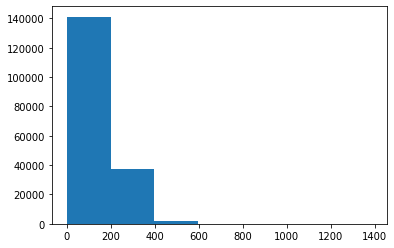

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

Okay, looks like most of the sequences are between 0 and 200 characters long.

I will use NumPy's percentile to figure out what length covers 95% of our sequences.

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Wonderful, now I know the sequence length which covers 95% of sequences, I'll use that in our TextVectorization layer as the output_sequence_length parameter.

I'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

Nice! Now I've adapted our char_vectorizer to our character-level sequences, I'll check out some characteristics about it using the get_vocabulary() method.

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


I can also test it on random sequences of characters to make sure it's working.

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   p a t i e n t s   i n   g r o u p   @   h a d   a   h i g h e r   i n c i d e n c e   o f   c o m p l i c a t i o n s   (   @   s e r o m a s   ,   @   c e n t r a l   n e c r o s e s   a n d   d e h i s c e n c e   )   ,   a n d   o n e   p a t i e n t   u n d e r w e n t   s e c o n d a r y   s u t u r e s   .

Length of chars: 133

Vectorized chars:
[[ 3 13  2 14  5  3  4  2  6  3  9  4  6 18  8  7 16 14 13  5 10  5 13  4
  18 13  2  8  4  6 11  4 10  2  6 11  2  7 17 11  7 15 14 12  4 11  5  3
   4  7  6  9  9  2  8  7 15  5  9 11  2  6  3  8  5 12  6  2 11  8  7  9
   2  9  5  6 10 10  2 13  4  9 11  2  6 11  2  5  6 10  7  6  2 14  5  3
   4  2  6  3 16  6 10  2  8 20  2  6  3  9  2 11  7  6 10  5  8 19  9 16
   3 16  8  2  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 

I've noticed sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to my model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

**Creating a character-level embedding**

I've got a way to vectorize my character-level sequences, now's time to create a character-level embedding.

Just like the custom token embedding, I can do so using the tensorflow.keras.layers.Embedding class.

My character-level embedding layer requires an input dimension and output dimension.

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since I am following the structure of the model in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf (Neural Networks for Joint Sentence Classification in Medical Paper Abstracts), the output dimension of the character embedding (output_dim) will be 25.

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True,
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   p a t i e n t s   i n   g r o u p   @   h a d   a   h i g h e r   i n c i d e n c e   o f   c o m p l i c a t i o n s   (   @   s e r o m a s   ,   @   c e n t r a l   n e c r o s e s   a n d   d e h i s c e n c e   )   ,   a n d   o n e   p a t i e n t   u n d e r w e n t   s e c o n d a r y   s u t u r e s   .

Embedded chars (after vectorization and embedding):
[[[-0.04323112 -0.00342289 -0.04924718 ...  0.02448651  0.0253838
    0.00403876]
  [-0.02587858 -0.04919945  0.04928596 ...  0.00941055  0.00105878
   -0.01139717]
  [ 0.03999174  0.01875475 -0.01554634 ... -0.00303191  0.02363718
    0.03685058]
  ...
  [ 0.01953119 -0.00961949 -0.01241543 ... -0.02070141  0.00870806
   -0.00362263]
  [ 0.01953119 -0.00961949 -0.01241543 ... -0.02070141  0.00870806
   -0.00362263]
  [ 0.01953119 -0.00961949 -0.01241543 ... -0.02070141  0.00870806
   -0.00362263]]]

Character embedding shape: (1, 290, 25)


Wonderful! Each of the characters in my sequences gets turned into a 25 dimension embedding.

**Building a Conv1D model to fit on character embeddings**

Now that I've got a way to turn our character-level sequences into numbers (char_vectorizer) as well as numerically represent them as an embedding (char_embed) I will test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as my custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

    ``` Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability) ```

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_________________________________

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

Just like my token-level sequence model, to save time with my experiments, I'll fit the character-level model on 10% of batches.


In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 27ms/step - loss: 1.2590 - accuracy: 0.4923 - val_loss: 1.0335 - val_accuracy: 0.5814
Epoch 2/3
562/562 [==============================] - 15s 26ms/step - loss: 1.0034 - accuracy: 0.6004 - val_loss: 0.9537 - val_accuracy: 0.6230
Epoch 3/3
562/562 [==============================] - 15s 26ms/step - loss: 0.9332 - accuracy: 0.6335 - val_loss: 0.8813 - val_accuracy: 0.6566


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.8961 - accuracy: 0.6522


[0.8960910439491272, 0.652191162109375]

Nice! Looks like my character-level model is working therefore I will now make some predictions with it and evaluate them.

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.1653218 , 0.4552516 , 0.09330181, 0.16768137, 0.1184434 ],
       [0.21574453, 0.4831323 , 0.03541269, 0.20983405, 0.0558764 ],
       [0.05942888, 0.35103634, 0.09055124, 0.39720556, 0.10177797],
       ...,
       [0.03401258, 0.02514098, 0.09806283, 0.02593117, 0.81685245],
       [0.02684552, 0.2236182 , 0.3128191 , 0.05149481, 0.3852225 ],
       [0.56004864, 0.23896472, 0.13282551, 0.05913081, 0.00903027]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.21911823116643,
 'f1': 0.6424008824556575,
 'precision': 0.6414499470334941,
 'recall': 0.6521911823116643}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

**Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)**

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far I've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, I am going to go through the following steps:

  1. Create a token-level model (similar to model_1)
  2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
  3. Combine (using layers.Concatenate) the outputs of 1 and 2
  4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
  5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

There's a lot going on here, I will get a summary and plot my model to visualize what's happening.

In [ ]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [ ]:
! pip install plot_model

In [ ]:
! pip install tf

  Created wheel for tf: filename=tf-1.0.0-py3-none-any.whl size=1285 sha256=f0f30b2483541a3363f332b5b9a0f57c4fc285c8b6f1c204a7ff522952a1194e
  Stored in directory: /root/.cache/pip/wheels/db/c7/58/cca67875b41ff853d3fdaa20b54a780ef2e045fbcacaef1ee3
Successfully built tf


In [ ]:
! pip install keras

In [ ]:
tf.keras.utils


<module 'tensorflow.keras.utils' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/utils/__init__.py'>

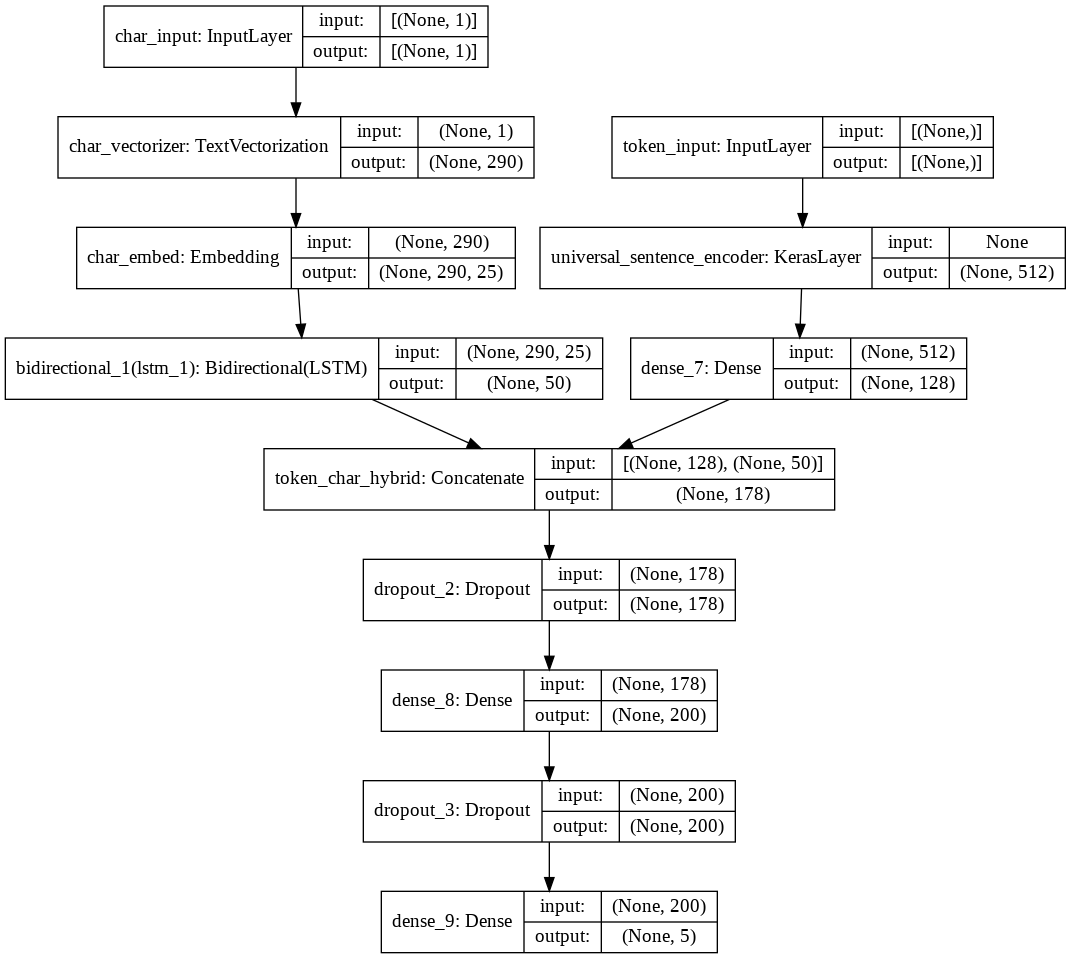

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

Now that's a good looking model. I will compile it just as I have the rest of my models.

    🔑 **Note:** Section 4.2 of https://arxiv.org/pdf/1612.05251.pdf (Neural Networks for Joint Sentence Classification in Medical Paper Abstracts) mentions using the SGD (stochastic gradient descent) optimizer, however, to stay consistent with our other models, we're going to use the Adam optimizer. As an exercise, you could try using `tf.keras.optimizers.SGD` instead of `tf.keras.optimizers.Adam` and compare the results.

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

And again, to keep the experiments fast, I'll fit the token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

I can do this by creaing a tf.data.Dataset with a tuple as it's first input, for example:
  * ((token_data, char_data), (label))


**Combining token and character data into a tf.data dataset**

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

**Fitting a model on token and character-level sequences**

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 181s 304ms/step - loss: 0.9645 - accuracy: 0.6200 - val_loss: 0.7661 - val_accuracy: 0.7041
Epoch 2/3
562/562 [==============================] - 167s 298ms/step - loss: 0.7880 - accuracy: 0.6998 - val_loss: 0.7080 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 167s 297ms/step - loss: 0.7668 - accuracy: 0.7074 - val_loss: 0.6841 - val_accuracy: 0.7467


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 76s 80ms/step - loss: 0.6867 - accuracy: 0.7385


[0.686748206615448, 0.7385144829750061]

Nice! The token-character hybrid model has come to life!

To make predictions with it, since it takes multiplie inputs, I can pass the predict() method a tuple of token-level sequences and character-level sequences.

I can then evaluate the predictions as I've done before.

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs


array([[4.1528285e-01, 3.5179317e-01, 5.8087935e-03, 2.1927951e-01,
        7.8357486e-03],
       [3.7692216e-01, 4.4762018e-01, 4.7117197e-03, 1.6718194e-01,
        3.5640146e-03],
       [3.2370266e-01, 1.1310002e-01, 4.7239091e-02, 4.9043602e-01,
        2.5522187e-02],
       ...,
       [1.0775465e-03, 1.3375396e-02, 8.4989257e-02, 4.2407756e-04,
        9.0013373e-01],
       [1.0230717e-02, 8.2437277e-02, 1.8795182e-01, 4.6342486e-03,
        7.1474594e-01],
       [2.9629672e-01, 3.2006261e-01, 3.0968088e-01, 1.8798269e-02,
        5.5161510e-02]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.85144975506421,
 'f1': 0.7357229242525404,
 'precision': 0.7372241865962628,
 'recall': 0.7385144975506421}

**Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embedding**

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle I can add in.

What if I engineered our own features into the model?
Meaning, what if I took my own knowledge about the data and encoded it in a numerical way to give my model more information about the samples?
The process of applying your own knowledge to build features as input to a model is called **feature engineering.**

Can I think of something important about the sequences we're trying to classify?

If I were to look at an abstract, would I expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beggining and sequences labelled OBJECTIVE at the end?

Abstracts typically come in a sequential order, such as:

  * OBJECTIVE ...
  * METHODS ...
  * METHODS ...
  * METHODS ...
  * RESULTS ...
  * CONCLUSIONS ...

Or

  * BACKGROUND ...
  * OBJECTIVE ...
  * METHODS ...
  * METHODS ...
  * RESULTS ...
  * RESULTS ...
  * CONCLUSIONS ...
  * CONCLUSIONS ..

Of course, I can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

  * Sentence 1 of 10 ...
  * Sentence 2 of 10 ...
  * Sentence 3 of 10 ...
  * Sentence 4 of 10 ...
  * ...

I noticed this when I created our `preprocess_text_with_line_numbers() function.` When I read in a text file of abstracts, I counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

In [ ]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to the model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

I can use these features because they will be available at test time.

Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to the model. The beautiful thing is, these features will be available at test time (I can just count the number of sentences in an abstract and the number of each one).

Meaning, if I were to predict the labels of sequences in an abstract the model had never seen, I could count the number of lines and the track the position of each individual line and pass it to the model.


**Create positional embeddings**

Okay, enough talk about positional embeddings, I'll create them.

Since the "line_number" and "total_line" columns are already numerical, I could pass them as they are to the model.

But to avoid the model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode the "line_number" and "total_lines" features.

To do this, I can use the `tf.one_hot` utility.

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what I should set the depth parameter to, let's investigate the distribution of the "line_number" column.

🔑 **Note:** When it comes to one-hot-encoding the features, Scikit-Learn's OneHotEncoder class is another viable option here.

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

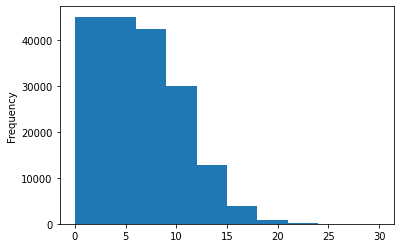

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, I will set the depth parameter of tf.one_hot to 15.

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

🔑 **Note:** I could create a one-hot tensor which has room for all of the potential values of "line_number" (depth=30), however, this would end up in a tensor of double the size of our current one (depth=15) where the vast majority of values are 0. Plus, only ~2,000/180,000 samples have a "line_number" value of over 15. So I would not be gaining much information about the data for doubling my feature space. This kind of problem is called the **curse of dimensionality**. However, since I am working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the depth parameter as an extension.

In [ ]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

I can do the same as I've done for the "line_number" column witht he "total_lines" column. First, I'll find an appropriate value for the depth parameter of tf.one_hot.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()


11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

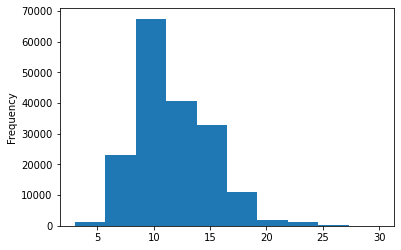

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();


Looking at the distribution of the "total_lines" column, a value of 20 looks like it covers the majority of samples.

I can confirm this with np.percentile().

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples


20.0

Beautiful! Plenty of converage. I will now one-hot-encode the "total_lines" column just as I did the "line_number" column.

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

**Building a tribrid embedding model**

Positional embedding tensors ready.

It's time to build the biggest model I've ever built yet. One which incorporates token embeddings, character embeddings and the newly crafted positional embeddings.

More specifically I am going to go through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of (Neural Networks for Joint Sentence Classification in Medical Paper Abstracts) https://arxiv.org/pdf/1612.05251.pdf 
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model


In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

There's a lot going on here... I'll visualize what's happening with a summary by plotting our model.

In [ ]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      1750        char_vectorizer[3][0]            
___________________________________________________________________________________________

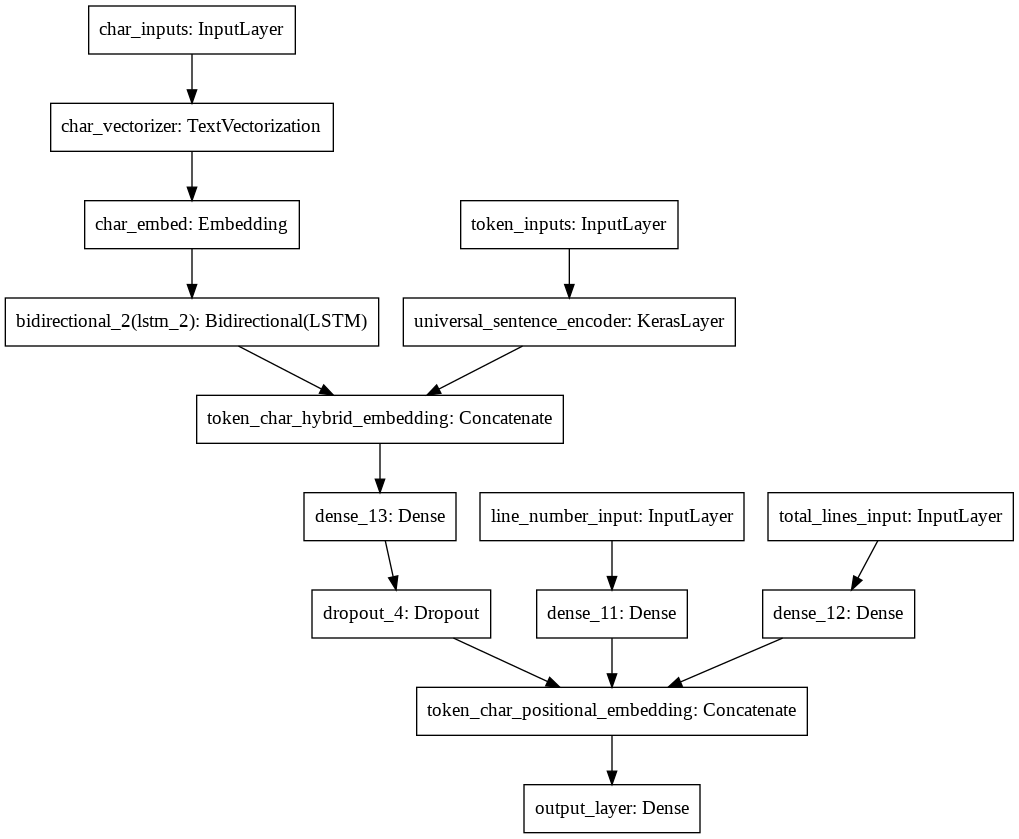

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)


Visualizing the model makes it much easier to understand.

Essentially what I am doing is trying to encode as much information about the sequences as possible into various embeddings (the inputs to my model) so that the model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

The model is looking very similar to the model shown in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts. However, a few differences still remain:

  * I'm using pretrained TensorFlow Hub token embeddings instead of GloVe emebddings.
  * I'm using a Dense layer on top of the token-character hybrid embeddings instead of a bi-LSTM layer.
  * Section 3.1.3 of the paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order) but it isn't shown in Figure 1. To makeup for the lack of this layer in the model, I've created the positional embeddings layers.
  * Section 4.2 of the paper mentions the token and character embeddings are updated during training, the pretrained TensorFlow Hub embeddings remain frozen.
  * The paper uses the SGD optimizer but I am going to stick with Adam.

All of the differences above are potential extensions of this project.


In [ ]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f793ddf3110> True
<tensorflow.python.keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f794ab78710> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f793de23750> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f794505f690> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f794ec32310> False
<tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f793dda4d10> True
<tensorflow.python.keras.layers.merge.Concatenate object at 0x7f794260f750> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f793dd85f10> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f793d86f550> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f793d7b7e90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f79426945d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f793da08fd0> Tru

Now that the model is constructed, I will compile it.

This time, I will introduce a new parameter to the loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

  * [0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:

  * [0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

    
  📖 **Resource:** For more on label smoothing, see the great blog post by PyImageSearch, (Label smoothing with Keras, TensorFlow, and Deep Learning.) https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

**Create tribrid embedding datasets and fit tribrid model**

Model compiled!

Again, to keep the experiments swift, I will fit on 20,000 examples for 3 epochs.

This time the model requires four feature inputs:

  1. Train line numbers one-hot tensor (train_line_numbers_one_hot)
  2. Train total lines one-hot tensor (train_total_lines_one_hot)
  3. Token-level sequences tensor (train_sentences)
  4. Char-level sequences tensor (train_chars)

I can pass these as tuples to the tf.data.Dataset.from_tensor_slices() method to create appropriately shaped and batched PrefetchedDataset's.

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 195s 329ms/step - loss: 1.0929 - accuracy: 0.7284 - val_loss: 0.9855 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 181s 321ms/step - loss: 0.9754 - accuracy: 0.8108 - val_loss: 0.9578 - val_accuracy: 0.8191
Epoch 3/3
562/562 [==============================] - 181s 322ms/step - loss: 0.9587 - accuracy: 0.8178 - val_loss: 0.9482 - val_accuracy: 0.8291


Tribrid model trained! Time to make some predictions with it and evaluate them just as we've done before.

In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 71s 71ms/step


array([[0.5186244 , 0.12604395, 0.00966889, 0.32326838, 0.02239434],
       [0.55725545, 0.0939054 , 0.04517962, 0.29154992, 0.01210966],
       [0.28760627, 0.12394436, 0.10863619, 0.40394574, 0.07586744],
       ...,
       [0.04311839, 0.11463808, 0.04815607, 0.03457358, 0.75951385],
       [0.02730623, 0.32079363, 0.08606838, 0.0243635 , 0.54146826],
       [0.18565753, 0.5680654 , 0.12329908, 0.0407069 , 0.08227106]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.91738382099828,
 'f1': 0.8280829248745641,
 'precision': 0.8275152361996053,
 'recall': 0.8291738382099828}

**Compare model results**

Far out, I've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

I'll also be able to compare the model  to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of my model results are in dictionaries, I will combine them into a pandas DataFrame to visualize them.

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.412551,0.780477,0.784126,0.781692
pretrained_token_embed,71.412022,0.714742,0.714120,0.711188
custom_char_embed_conv1d,65.219118,0.641450,0.652191,0.642401
hybrid_char_token_embed,73.851450,0.737224,0.738514,0.735723
tribrid_pos_char_token_embed,82.917384,0.827515,0.829174,0.828083


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

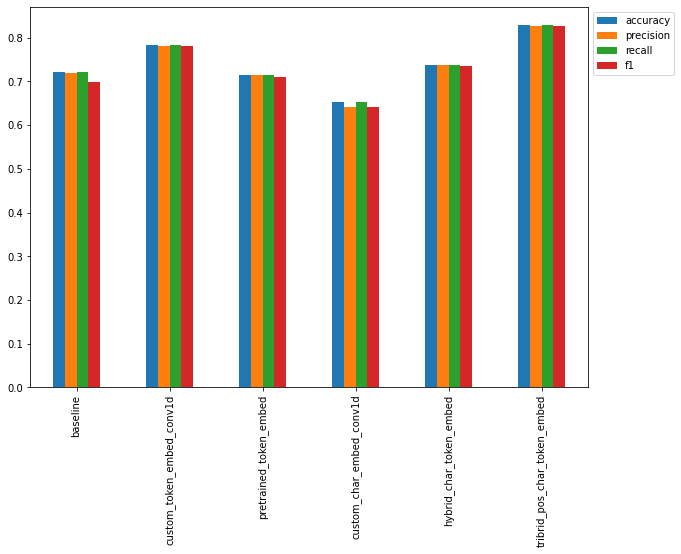

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Since the (PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts) https://arxiv.org/pdf/1710.06071.pdf paper compares their tested model's F1-scores on the test dataset, I will take my model's F1-scores.

🔑 Note: I could've also made these comparisons in TensorBoard using the TensorBoard callback during training.

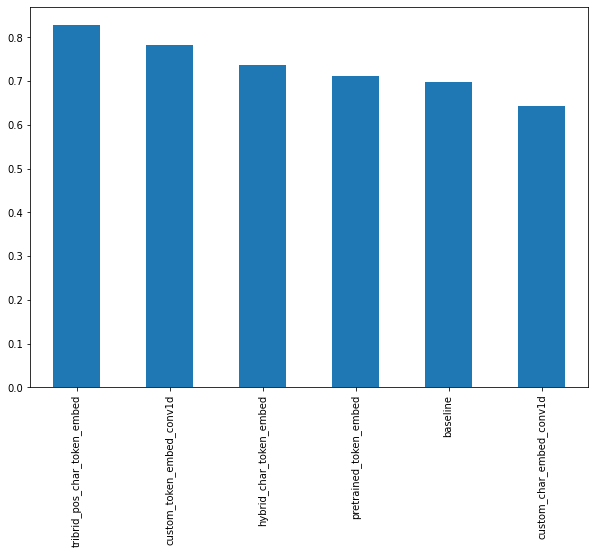

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Nice! Based on F1-scores, it looks like my tribrid embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the (PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts) https://arxiv.org/pdf/1710.06071.pdf paper, my model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).
There are some things to note about this difference:

  * My models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.
    * This is often the case in machine learning experiments though, make sure training works on a smaller number of samples, then upscale when needed (an extension to this project will be training a model on the full dataset).
  * My model's prediction performance levels have been evaluated on the validation dataset not the test dataset (we'll evaluate our best model on the test dataset shortly).


**Save and load best performing model**

Since I've been through a fair few experiments, it's a good idea to save the best performing model so that I can reuse it without having to retrain it.

I can save my best performing model by calling the save() method on it.

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")


**Make predictions and evalaute them against the truth labels**

To make sure my model is saved and loaded correctly, I will make predictions with it, evaluate them and then compare them to the prediction results I calculated earlier.

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 69s 69ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 82.91738382099828,
 'f1': 0.8280829248745641,
 'precision': 0.8275152361996053,
 'recall': 0.8291738382099828}

In [ ]:
# Compare loaded model results with original trained model results (should return no errors)
assert model_5_results == loaded_model_results



It's worth noting that loading in a SavedModel unfreezes all layers (makes them all trainable). So if I want to freeze any layers, I'll have to set their trainable attribute to False.

In [ ]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      1750        char_vectorizer[0][0]            
___________________________________________________________________________________________


**Evaluate model on test dataset**

To make my model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, I will make predictions on the test dataset and evaluate them.

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 64s 68ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.41911398705824,
 'f1': 0.823003934174076,
 'precision': 0.8224455054874941,
 'recall': 0.8241911398705823}

It seems my best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as mine gets ~82.1 F1-score).

However, my model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. I also haven't fine-tuned my pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions I could try to improve my results.

**Find most wrong**

One of the best ways to investigate where my model is going wrong (or potentially where my data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give valuable information on how to improve further models or fix the labels in the data.

I will write write some code to help isualize the most wrong predictions from the test dataset.

First I'll convert all of the integer-based test predictions into their string-based class names.

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 3.9 s, sys: 15.8 ms, total: 3.92 s
Wall time: 3.93 s


Now I'll enrich our test DataFame with a few values:

  * A "prediction" (string) column containing my model's prediction for a given sample.
  * A "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.
  * A "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.487305,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.310322,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.770807,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.638718,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.761818,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.883750,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.511915,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.488076,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.550916,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.548093,True


Looking good! Having my data like this, makes it very easy to manipulate and view in different ways.
I will now sort out the DataFrame to find the samples with the highest "pred_prob" and where the prediction was wrong ("correct" == False)?

In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong


,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.942740,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.942331,False
1221,RESULTS,data were collected prospectively for @ months...,3,13,METHODS,0.925720,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.919164,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.917504,False
...,...,...,...,...,...,...,...
28391,RESULTS,cox proportional hazards analyses were used to...,3,10,METHODS,0.824882,False
19425,RESULTS,a decision-analytical model based on patient-l...,3,12,METHODS,0.824739,False
14108,CONCLUSIONS,unique identifier : nct@ .,15,15,BACKGROUND,0.823354,False
18002,RESULTS,application of loperamide hcl in a liposomal g...,11,20,CONCLUSIONS,0.822888,False


Now I've got a subset of my model's most wrong predictions, I will write some code to visualize them.

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9427400827407837, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9423307180404663, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.92572021484375, Line number: 3, Total lines: 13

Text:
data were collected prospectively for @ months beginning after completion of the first @ group clinic appointments ( @ months post randomization ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9191641211509705, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9175035357475281, Line number: 4, Total lines: 13

Text:
baseline measures 